In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline

In [49]:


class NeuralNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        self.numLayers = len(layers) - 1
        self.params = {}
        self.grad = {}

        for i in range(self.numLayers):
            self.params['W' + str(i+1)] = tf.Variable(np.random.normal(size=(self.layers[i], self.layers[i+1])))
            self.params['b' + str(i+1)] = tf.Variable(np.random.normal(size=(self.layers[i+1])))

    def feedforward(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32)

        for i in range(self.numLayers):
            W = tf.cast(self.params['W' + str(i+1)], dtype=tf.float32)
            b = tf.cast(self.params['b' + str(i+1)], dtype=tf.float32)

            Z = tf.matmul(A, W) + b

            if i != self.numLayers - 1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

    def computeLoss(self, A, y):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=A)
        return tf.reduce_mean(loss)

    def updateParams(self, lr):
        for i in range(self.numLayers):
            self.params['W' + str(i+1)].assign_sub(lr * self.grad['W' + str(i+1)])
            self.params['b' + str(i+1)].assign_sub(lr * self.grad['b' + str(i+1)])

    def predict(self, X):
        A = self.feedforward(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)

    def trainOnBatch(self, X, y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            A = self.feedforward(X)
            loss = self.computeLoss(A, y)

        for i in range(self.numLayers):
            self.grad['W' + str(i+1)] = tape.gradient(loss, self.params['W' + str(i+1)])
            self.grad['b' + str(i+1)] = tape.gradient(loss, self.params['b' + str(i+1)])
        del tape
        self.updateParams(lr)

    def train(self, X_train, y_train, X_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'train_acc': [],
            'train_loss': [],
            'val_acc': []
        }

        for e in range(epochs):
            epochsTrainLoss = 0
            print('Epoch {}'.format(e), end='-')
            for i in range(steps_per_epoch):
                X_batch = X_train[i * batch_size:(i + 1) * batch_size]
                y_batch = y_train[i * batch_size:(i + 1) * batch_size]

                self.trainOnBatch(X_batch, y_batch, lr)
                batch_loss = self.computeLoss(self.feedforward(X_batch), y_batch)
                epochsTrainLoss += batch_loss

                if i % int(steps_per_epoch / 10) == 0:
                    print('-', end='')

            history['train_loss'].append(epochsTrainLoss / steps_per_epoch)
            train_preds = self.predict(X_train)
            train_acc = np.mean(np.argmax(y_train, axis=1) == train_preds.numpy())
            history['train_acc'].append(train_acc)
            val_preds = self.predict(X_test)
            val_acc = np.mean(np.argmax(y_test, axis=1) == val_preds.numpy())
            history['val_acc'].append(val_acc)

            print('Train_acc:{}  . Val_acc:{}'.format(train_acc, val_acc))
        return history


In [43]:
def load():
    (X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()
    X_train = np.reshape(X_train,(X_train.shape[0],784))/255.0
    X_test = np.reshape(X_test,(X_test.shape[0],784))/255.0
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (X_train,y_train),(X_test,y_test)

def plot_random_images(x,y,p=None):
    indices = np.random.choice(range(x.shape[0]),10)
    y = np.argmax(y,axis=1)

    if p is None :
        p = y
    plt.figure(figsize=(10,5))
    for i , index in enumerate(indices):
        plt.subplot(2,5,i+1)
        plt.imshow(x[index].reshape((28,28)),cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]),color = col)


In [8]:
(X_train,y_train),(X_test,y_test) = load()

11490434/11490434 [==============================] - 4s 0us/step


AttributeError: 'NoneType' object has no attribute 'show'

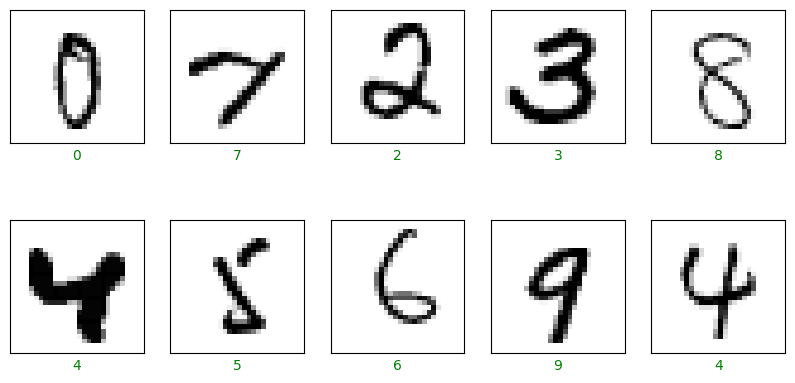

In [44]:
plot_random_images(X_train,y_train).show()

In [50]:
net = NeuralNetwork([784,128,128,10])


In [40]:
batch_size = 120
epochs  = 7
steps_per_epochs = int(X_train.shape[0]/batch_size)
lr = 3e-3


In [51]:
history = net.train(X_train,y_train,X_test,y_test,epochs,steps_per_epochs,batch_size,lr)

Epoch 0-----------Train_acc:0.8171333333333334  . Val_acc:0.8207
Epoch 1-----------Train_acc:0.8466  . Val_acc:0.8477
Epoch 2-----------Train_acc:0.8597  . Val_acc:0.8606
Epoch 3-----------Train_acc:0.8695166666666667  . Val_acc:0.8696
Epoch 4-----------Train_acc:0.8727833333333334  . Val_acc:0.8711
Epoch 5-----------Train_acc:0.8755  . Val_acc:0.8728
Epoch 6-----------Train_acc:0.88  . Val_acc:0.8766
